In [137]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn import tree

# Librerías adicionales
import itertools  # Para generar combinaciones de columnas
import matplotlib.patches as mpatches  # Para manejar gráficos

# Importación de módulo personalizado
import payments_manager as pm

# Inicialización del proyecto (si es necesario)
# pm.help()  # Si se necesita ayuda del módulo
# pm.reset()  # Para reiniciar cualquier configuración anterior
# pm.init()  # Si es necesario inicializar el módulo con opciones (por ejemplo, debug=True)

# Cargar y preparar el DataFrame df_jo
df_jo = pm.df('df_jo')  # Cargar el DataFrame desde 'payments_manager'
df_jo.info()  # Ver información básica sobre el DataFrame

# Ordenar el DataFrame df_jo por la columna 'id_cr' y resetear índices
df_jo = df_jo.sort_values(by=["id_cr"]).reset_index(drop=True)

# Crear una copia del DataFrame para su posterior uso
df_jo_cp = df_jo.copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         32092 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

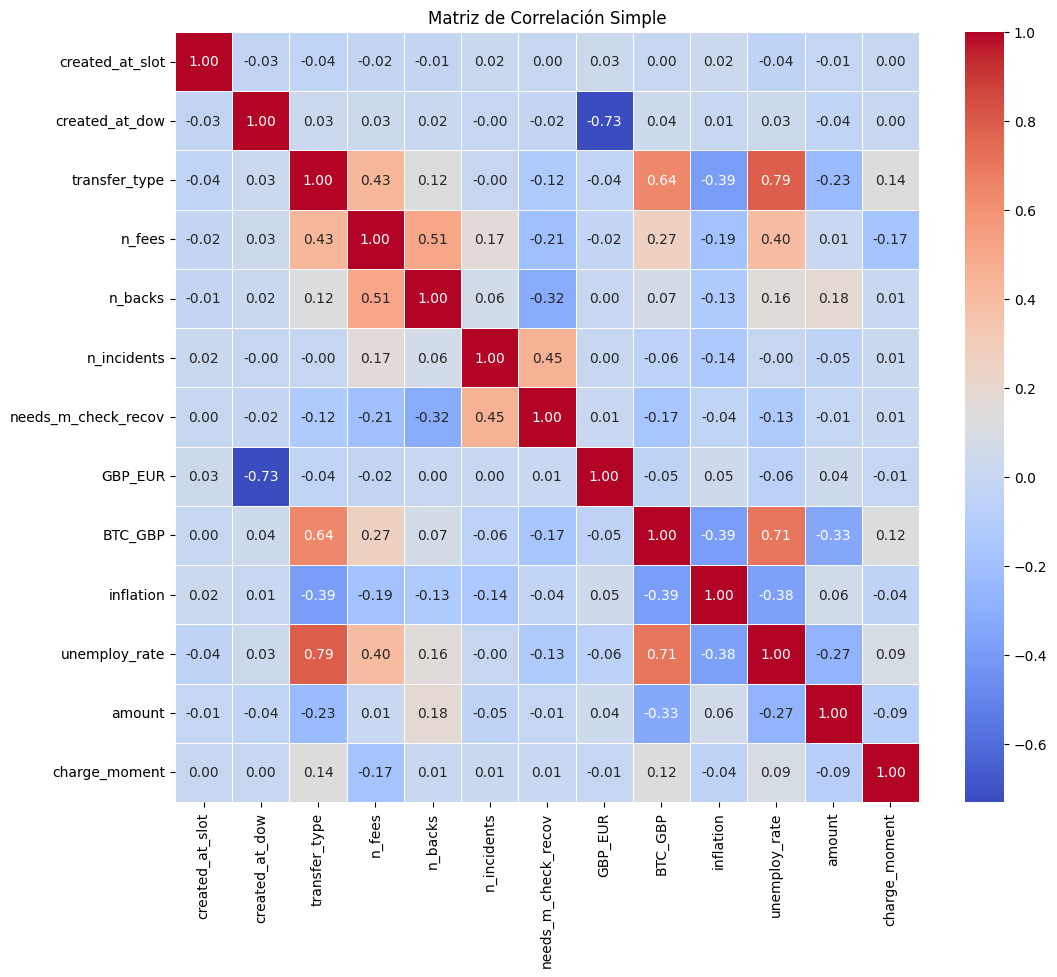

In [168]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type', 'n_fees', 'n_backs','n_incidents', 'needs_m_check_recov','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment']

# Crear un nuevo DataFrame solamente con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Reasignar valores en la columna 'transfer_type'
df_simpl = df_simpl.copy()
df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})
df_simpl['charge_moment'] = df_simpl['charge_moment'].map({'before': 0, 'after': 1})

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [207]:
# df nuevos clientes
new_users_df = df_jo_cp[(df_jo_cp['n_fees'] == 0) & (df_jo_cp['n_backs'] == 0) & (df_jo_cp['n_incidents'] == 0)]
new_users_df

# df clientes repetitivos
rep_users_df = df_jo_cp[(df_jo_cp['n_fees'] > 0 ) & (df_jo_cp['n_backs'] > 0) & (df_jo_cp['n_incidents'] > 0)]
rep_users_df


,id_cr,id_fe,fe_cr_id,user_id,active,created_at,created_at_fe,amount,fee,stat_cr,...,needs_m_check_recov,n_fees,n_backs,n_recovery,n_incidents,created_at_d,GBP_EUR,BTC_GBP,inflation,unemploy_rate
1495,1566,1493,1566.0,907,1,2020-05-05 11:02:00.290074,2020-07-16 01:00:09.444410,100.0,5.0,money_back,...,1,1,2,1,2,2020-05-05,1.14100,7236.208496,0.5,4.2
1681,1746,843,1746.0,138,1,2020-05-13 21:50:18.687852,2020-06-30 15:12:15.392246,100.0,5.0,money_back,...,1,1,2,0,1,2020-05-13,1.12963,7573.682129,0.5,4.2
1682,1746,985,1746.0,138,1,2020-05-13 21:50:18.687852,2020-07-03 13:28:26.684352,100.0,5.0,money_back,...,1,1,2,0,4,2020-05-13,1.12963,7573.682129,0.5,4.2
1684,1746,970,1746.0,138,1,2020-05-13 21:50:18.687852,2020-07-03 04:46:10.461877,100.0,5.0,money_back,...,1,1,2,0,3,2020-05-13,1.12963,7573.682129,0.5,4.2
1685,1746,899,1746.0,138,1,2020-05-13 21:50:18.687852,2020-07-01 13:52:18.046054,100.0,5.0,money_back,...,1,1,2,0,2,2020-05-13,1.12963,7573.682129,0.5,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32062,26978,0,NaN,69442,1,2020-11-01 19:04:45.766724,NaT,100.0,0.0,money_back,...,1,1,1,1,1,2020-11-01,0.00000,10627.522461,0.7,5.3
32078,26996,21144,26996.0,9452,1,2020-11-01 21:00:23.138884,2020-11-01 21:00:37.656408,100.0,5.0,money_back,...,1,2,2,1,1,2020-11-01,0.00000,10627.522461,0.7,5.3
32079,26997,21147,26997.0,29769,1,2020-11-01 21:12:31.454420,2020-11-01 21:12:39.609481,100.0,5.0,money_back,...,0,4,1,0,1,2020-11-01,0.00000,10627.522461,0.7,5.3
32087,27006,21181,27006.0,55916,1,2020-11-01 23:07:55.231487,2020-11-01 23:08:17.050811,50.0,5.0,money_back,...,0,2,1,0,1,2020-11-01,0.00000,10627.522461,0.7,5.3


In [206]:
# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts = df_simpl['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total = value_counts[0] + value_counts[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual = (value_counts[1] / total) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check: {needs_manual:.2f} %')


Porcentaje de operaciones con needs_m_check: 52.31 %


C:\Users\ammanzano\AppData\Local\Temp\ipykernel_5828\3565285435.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simpl2['transfer_type'] = df_simpl2['transfer_type'].map({'regular': 0, 'instant': 1})
C:\Users\ammanzano\AppData\Local\Temp\ipykernel_5828\3565285435.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simpl2['charge_moment'] = df_simpl2['charge_moment'].map({'before': 0, 'after': 1})


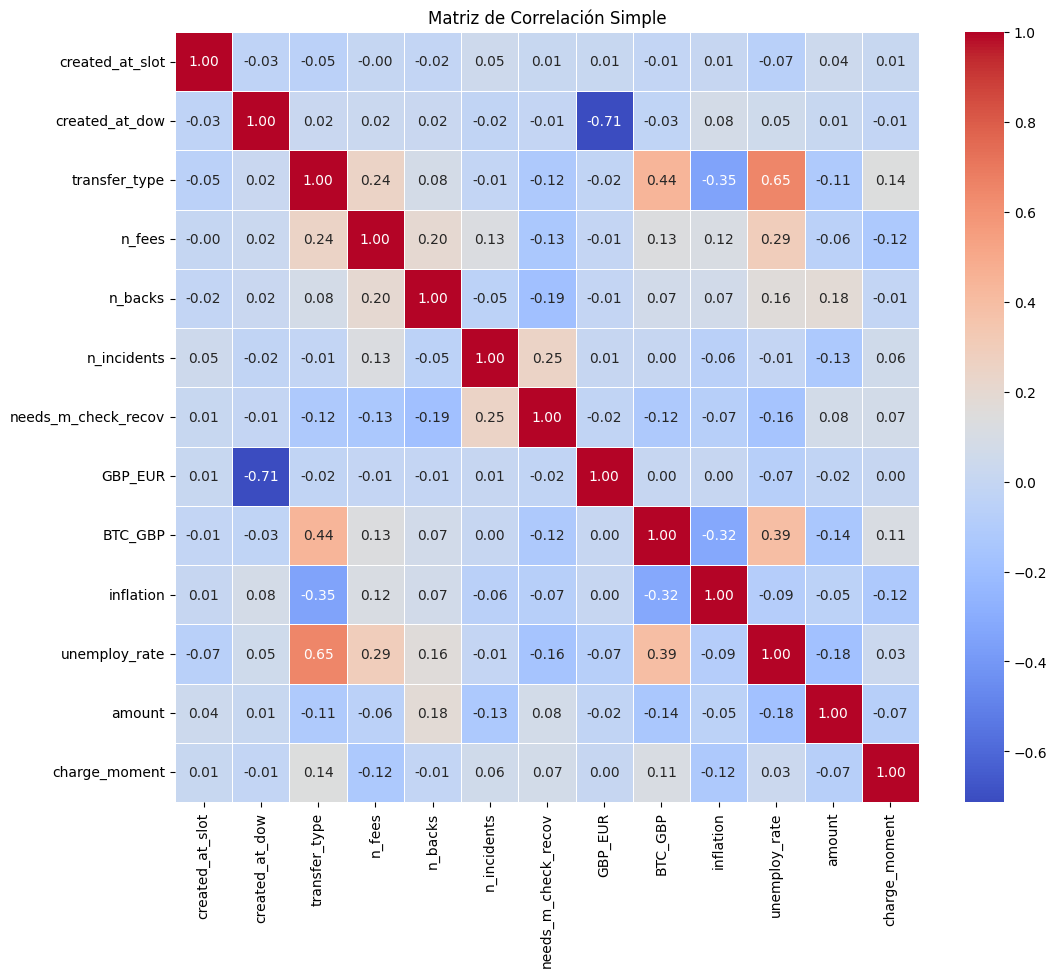

In [212]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas2 = ['created_at_slot', 'created_at_dow' ,'transfer_type', 'n_fees', 'n_backs','n_incidents', 'needs_m_check_recov','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment']

# Crear un nuevo DataFrame solamente con esas columnas
df_simpl2 = rep_users_df[columnas_deseadas]


df_simpl2['transfer_type'] = df_simpl2['transfer_type'].map({'regular': 0, 'instant': 1})
df_simpl2['charge_moment'] = df_simpl2['charge_moment'].map({'before': 0, 'after': 1})

# Calcular la matriz de correlación
m_corr_simpl = df_simpl2.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [213]:
# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts = df_simpl2['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total = value_counts[0] + value_counts[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual = (value_counts[1] / total) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check: {needs_manual:.2f} %')

Porcentaje de operaciones con needs_m_check: 60.92 %


In [142]:
# Crea la matriz de características y la var objetivo
X = df_simpl2.drop(columns=[
   'needs_m_check_recov',  
#    'created_at_slot',      
#    'created_at_dow',       
    'transfer_type',
#   'n_fees',
#    'n_backs',
#    'n_incidents',
 #   'GBP_EUR',
 #   'BTC_GBP',
    'inflation',      
    'unemploy_rate',
 # 'amount',

])
y = df_simpl2['needs_m_check_recov']  # La columna de la variable objetivo

print(X.shape)
print(y.shape)
X.head(50)

(5425, 8)
(5425,)


,created_at_slot,created_at_dow,n_fees,n_backs,n_incidents,GBP_EUR,BTC_GBP,amount
1495,11,1,1,2,2,1.14100,7236.208496,100.0
1681,21,2,1,2,1,1.12963,7573.682129,100.0
1682,21,2,1,2,4,1.12963,7573.682129,100.0
1684,21,2,1,2,3,1.12963,7573.682129,100.0
1685,21,2,1,2,2,1.12963,7573.682129,100.0
1688,23,2,2,2,2,1.12963,7573.682129,100.0
1689,23,2,1,2,2,1.12963,7573.682129,100.0
1710,8,3,1,1,1,1.13102,7957.521484,100.0
1774,16,4,1,1,6,1.13180,7706.900391,10.0
1810,17,4,1,1,4,1.13180,7706.900391,100.0


In [143]:
# MODELO DE ÁRBOL DE DECISIÓN

# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Árbol de Decisión
DT = tree.DecisionTreeClassifier()

# Entrenar el modelo con el conjunto de datos de entrenamiento
DT.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = DT.predict(test_X)




Precisión del modelo: 0.6396

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.55      0.53      0.54       431
           1       0.70      0.71      0.70       654

    accuracy                           0.64      1085
   macro avg       0.62      0.62      0.62      1085
weighted avg       0.64      0.64      0.64      1085


Importancia de las características (ordenadas por magnitud):
created_at_slot: 0.2304
BTC_GBP: 0.1961
n_incidents: 0.1560
GBP_EUR: 0.1224
n_fees: 0.0909
n_backs: 0.0878
created_at_dow: 0.0744
amount: 0.0421


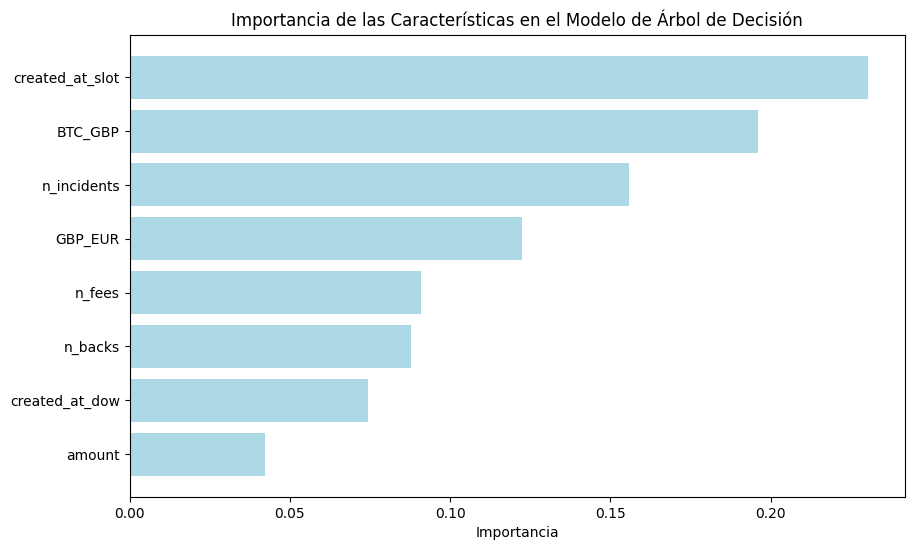

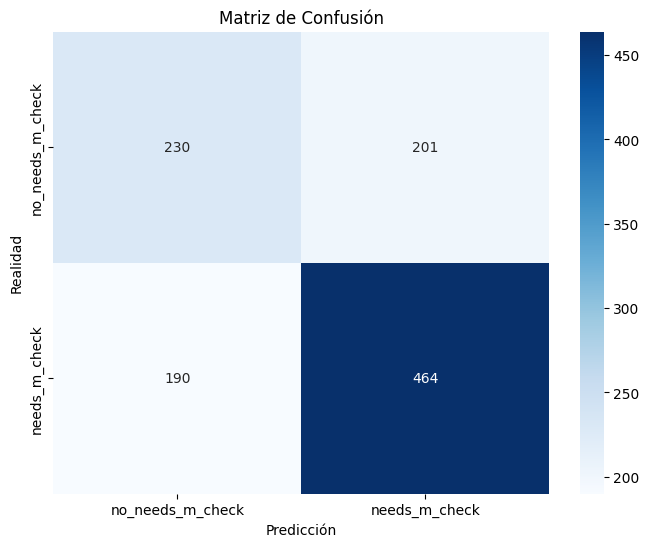

In [144]:
# Evaluación del rendimiento del modelo

# 1. Precisión del modelo
accuracy = DT.score(test_X, test_y)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(test_y, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X.columns

# Obtener las importancias de las características del modelo
feature_importances = DT.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características

# Graficar las importancias de las características
plt.figure(figsize=(10, 6))
features = [f[0] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]
importances = [f[1] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()



In [185]:
# MODELO RANDOM FOREST
X_rf = df_simpl2.drop(columns=[
    'needs_m_check_recov',  
#    'created_at_slot',      
#    'created_at_dow',       
#    'transfer_type',
#   'n_fees',    
#   'n_backs',
#    'n_incidents',
#    'GBP_EUR',
#    'BTC_GBP',
#    'inflation',      
#    'unemploy_rate',
#    'amount',

])
Y_rf = df_simpl2['needs_m_check_recov'] 


In [186]:
# Se escoge el modelo para evaluar el subset de atributos
RF = RandomForestClassifier()
# Se escoge el número de los atributos a seleccionar
rfe = RFE(RF)
rfe = rfe.fit(X_rf, Y_rf)
print('Mejores características: ',X_rf.columns[rfe.support_])


Mejores características:  Index(['created_at_slot', 'n_fees', 'n_backs', 'n_incidents', 'GBP_EUR',
       'BTC_GBP'],
      dtype='object')


In [187]:
# Crear el clasificador RandomForest
clf_rf_4 = RandomForestClassifier()

# Inicializar RFECV con validación cruzada (3-fold)
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=3, scoring='accuracy')  # 3-fold cross-validation

# Ajustar el modelo
rfecv = rfecv.fit(X_rf, Y_rf)

# Mostrar el número óptimo de características seleccionadas
print('Número óptimo de características:', rfecv.n_features_)

# Mostrar las mejores características seleccionadas
print('Mejores características:', X_rf.columns[rfecv.support_])

Número óptimo de características: 10
Mejores características: Index(['created_at_slot', 'created_at_dow', 'n_fees', 'n_backs', 'n_incidents',
       'GBP_EUR', 'BTC_GBP', 'unemploy_rate', 'amount', 'charge_moment'],
      dtype='object')


In [148]:
# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo RandomForest
RF = RandomForestClassifier()

# Entrenar el modelo con el conjunto de datos de entrenamiento
RF.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = RF.predict(test_X)




Precisión del modelo: 0.7014

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.55      0.60       431
           1       0.73      0.80      0.76       654

    accuracy                           0.70      1085
   macro avg       0.69      0.68      0.68      1085
weighted avg       0.70      0.70      0.70      1085


Importancia de las características (ordenadas por magnitud):
created_at_slot: 0.2161
BTC_GBP: 0.1800
n_incidents: 0.1757
GBP_EUR: 0.1260
n_backs: 0.0907
n_fees: 0.0890
created_at_dow: 0.0748
amount: 0.0477


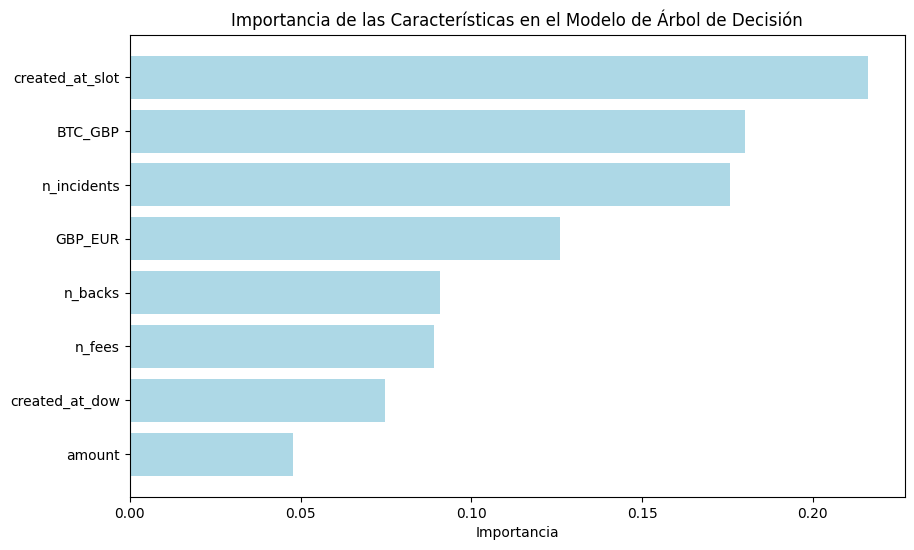

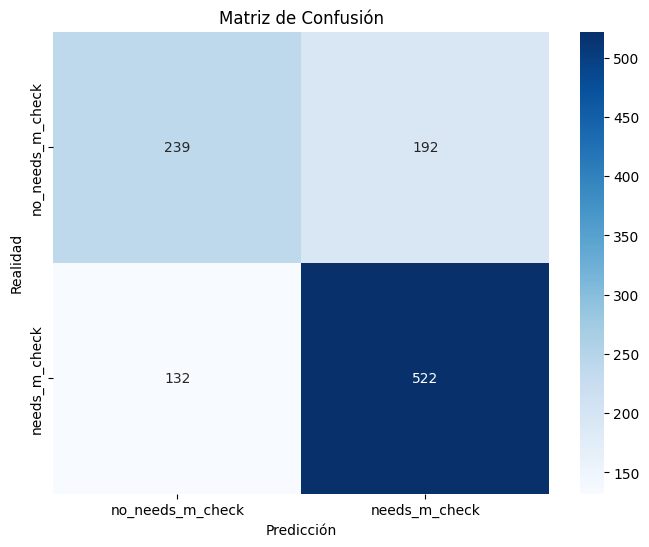

In [149]:
# Evaluación del rendimiento del modelo

# 1. Precisión del modelo
accuracy = RF.score(test_X, test_y)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(test_y, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X.columns

# Obtener las importancias de las características del modelo
feature_importances = RF.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características

# Graficar las importancias de las características
plt.figure(figsize=(10, 6))
features = [f[0] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]
importances = [f[1] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()


In [217]:
# NORMALIZACION Y ESCALADO

X_s = df_simpl.drop(columns=[
      'needs_m_check_recov',  
      # 'created_at_slot',      
      # 'created_at_dow',       
      # 'transfer_type',
      # 'n_fees',    
      # 'n_backs',
      # 'n_incidents',
      # 'GBP_EUR',
      # 'BTC_GBP',
      # 'inflation',      
      # 'unemploy_rate',
      # 'amount',
      # 'charge_moment',

])
Y_s = df_simpl['needs_m_check_recov'] 


col_names= [
      'created_at_slot',      
      'created_at_dow',       
      'transfer_type',
      'n_fees',    
      'n_backs',
      'n_incidents',
      'GBP_EUR',
      'BTC_GBP',
      'inflation',      
      'unemploy_rate',
      'amount',
      'charge_moment',

]

col_names2 =['needs_m_check_recov']
s_scaler = StandardScaler()
X_s = s_scaler.fit_transform(X_s)
X_s = pd.DataFrame(X_s, columns=col_names)
#Y_s = pd.DataFrame(Y_s, columns=col_names2)

print(X_s.shape)
print(Y_s.shape)


(32092, 12)
(32092,)


In [223]:
# Crear el clasificador RandomForest
clf_rf_4 = RandomForestClassifier()

# Inicializar RFECV con validación cruzada (3-fold)
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5, scoring='accuracy')  # 3-fold cross-validation

# Ajustar el modelo
rfecv = rfecv.fit(X_s, Y_s)

# Mostrar el número óptimo de características seleccionadas
print('Número óptimo de características:', rfecv.n_features_)

# Mostrar las mejores características seleccionadas
print('Mejores características:', X_s.columns[rfecv.support_])

Número óptimo de características: 1
Mejores características: Index(['n_incidents'], dtype='object')


In [219]:
# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X_s, Y_s, test_size=0.15, random_state=42)

# Crear el modelo RandomForest
RF = RandomForestClassifier()

# Entrenar el modelo con el conjunto de datos de entrenamiento
RF.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = RF.predict(test_X)


Precisión del modelo: 0.9254

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      2234
           1       0.92      0.94      0.93      2580

    accuracy                           0.93      4814
   macro avg       0.93      0.92      0.92      4814
weighted avg       0.93      0.93      0.93      4814


Importancia de las características (ordenadas por magnitud):
n_incidents: 0.5261
n_backs: 0.1379
n_fees: 0.0628
charge_moment: 0.0613
created_at_slot: 0.0571
BTC_GBP: 0.0454
GBP_EUR: 0.0266
amount: 0.0179
created_at_dow: 0.0178
transfer_type: 0.0161
unemploy_rate: 0.0158
inflation: 0.0153


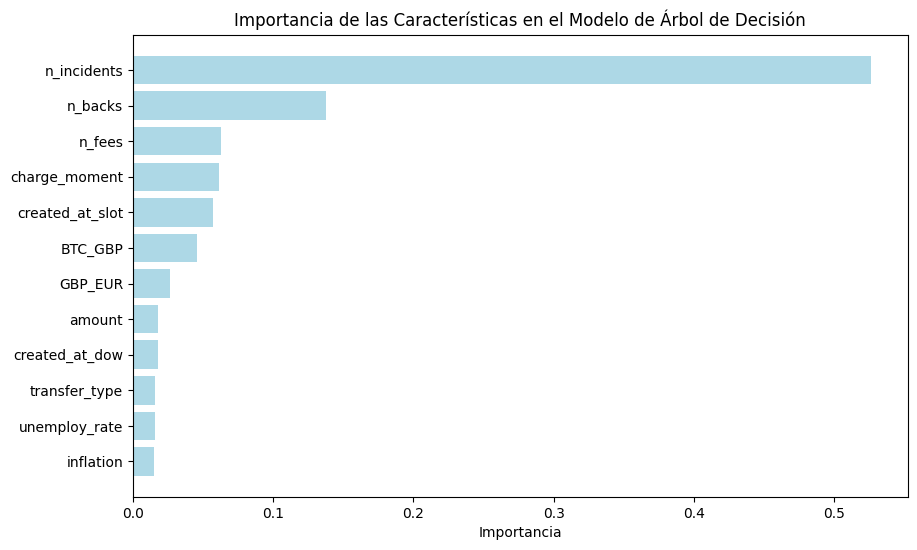

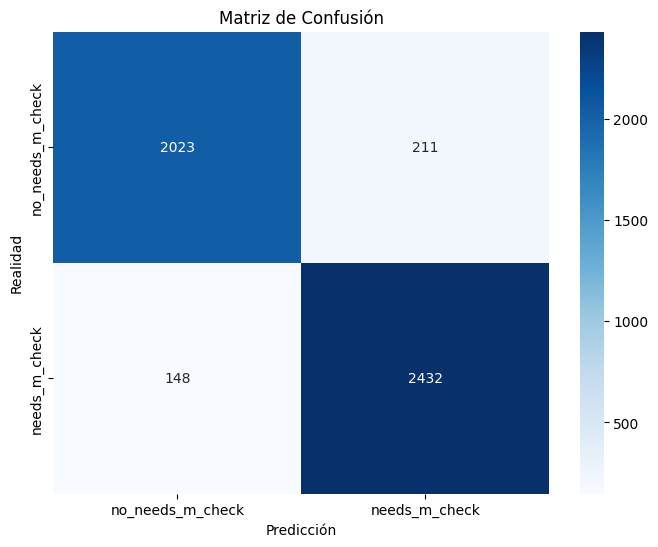

In [220]:
# Evaluación del rendimiento del modelo

# 1. Precisión del modelo
accuracy = RF.score(test_X, test_y)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(test_y, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X_s.columns

# Obtener las importancias de las características del modelo
feature_importances = RF.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características

# Graficar las importancias de las características
plt.figure(figsize=(10, 6))
features = [f[0] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]
importances = [f[1] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()